In [1]:
import gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pygame

from typing import (
    Tuple,
    Dict,
    Optional,
    Iterable
)
from matplotlib import (
    animation
)
from gym import (
    spaces
)
from gym.error import (
    DependencyNotInstalled
)
from pygame import (
    gfxdraw
)
from IPython.display import (
    HTML
)

from tqdm import (
    tqdm
)

class Maze(gym.Env):
    def __init__(self, exploring_starts: bool = False,
                 shaped_rewards: bool = False, size: int = 5) -> None:
        super().__init__()
        self.exploring_starts = exploring_starts
        self.shaped_rewards = shaped_rewards
        self.state = (size - 1, size - 1)
        self.goal  = (size - 1, size - 1)
        self.maze  = self.__create_maze__(size=size)
        self.distances = self.__compute_distance__(self.goal, self.maze)
        self.action_space = spaces.Discrete(n=4)
        self.action_space.action_meanings = {
            0: 'UP',
            1: 'RIGHT',
            2: 'DOWN',
            3: 'LEFT'
        }
        self.observation_space = spaces.MultiDiscrete([size, size])
        self.screen = None
        self.agent_transform = None

    def step(self, action: int) -> Tuple[Tuple[int, int], float, bool, Dict]:
        reward = self.compute_reward(self.state, action)
        self.state = self.__get_next_state__(self.state, action)
        done = self.state == self.goal
        info = {}
        return self.state, reward, done, info
    
    def reset(self) -> Tuple[int, int]:
        if self.exploring_starts:
            while self.state == self.goal:
                self.state = tuple(self.observation_space.sample())
        else:
            self.state = (0, 0)
        return self.state

    def render(self, mode="human") -> Optional[np.ndarray]:
        assert mode in ['human', 'rgb_array']

        screen_size = 600
        scale = screen_size / 5

        if self.screen is None:
            pygame.init()
            self.screen = pygame.Surface((screen_size, screen_size))

        surf = pygame.Surface((screen_size, screen_size))
        surf.fill((22, 36, 71))

        for row in range(5):
            for col in range(5):
                state = (row, col)
                for next_state in [(row + 1, col), (row - 1, col), (row, col + 1), (row, col - 1)]:
                    if next_state not in self.maze[state]:
                        #
                        # Add the geometry of the edges and walls (i.e. the boundaries between adjacent squares that are not connected)
                        #
                        row_diff, col_diff = np.subtract(next_state, state)
                        left = (col + (col_diff > 0)) * scale - 2 * (col_diff != 0)
                        right = ((col + 1) - (col_diff < 0)) * scale + 2 * (col_diff != 0)
                        top = (5 - (row + (row_diff > 0))) * scale - 2 * (row_diff != 0)
                        bottom = (5 - ((row + 1) - (row_diff < 0))) * scale + 2 * (row_diff != 0)
                        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (40, 199, 172))
        
        # Add the geometry of the goal square to the viewer
        left, right, top, bottom = scale * 4 + 10, scale * 5 - 10, scale - 10, 10
        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (40, 199, 172))

        # Add the geometry of the agent to the viewer
        agent_row = int(screen_size - scale * (self.state[0] + 0.5))
        agent_col = int(scale * (self.state[1] + 0.5))
        gfxdraw.filled_circle(surf, agent_col, agent_row, int(scale * 0.6 / 2), (228, 63, 90))

        surf = pygame.transform.flip(surf, False, True)
        self.screen.blit(surf, (0, 0))

        return np.transpose(
            np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
        )

    def close(self) -> None:
        if self.screen is not None:
            pygame.display.quit()
            pygame.quit()
            self.screen = None

    def compute_reward(self, state: Tuple[int, int], action: int) -> float:
        next_state = self.__get_next_state__(state, action)

        if self.shaped_rewards:
            return -(self.distances[next_state] / self.distances.max())
        return -float(state != self.goal)
    
    def simulate_step(self, state: Tuple[int, int], action: int):
        reward = self.compute_reward(state, action)
        next_state = self.__get_next_state__(state, action)
        done = next_state == self.goal
        info = {}
        return next_state, reward, done, info

    def __get_next_state__(self, state: Tuple[int, int], action: int) -> Tuple[int, int]:
        if action == 0:
            next_state = (state[0] - 1, state[1])
        elif action == 1:
            next_state = (state[0], state[1] + 1)
        elif action == 2:
            next_state = (state[0] + 1, state[1])
        elif action == 3:
            next_state = (state[0], state[1] - 1)
        else:
            raise ValueError('Action value not supported: ', action)
        
        if next_state in self.maze[state]:
            return next_state
        
        return state


    @staticmethod
    def __create_maze__(size: int) -> Dict[Tuple[int, int], Iterable[Tuple[int, int]]]:
        maze = {
            (row, col) : [(row - 1, col), (row + 1, col), (row, col - 1), (row, col + 1)]
            for row in range(size) 
            for col in range(size)
        }

        left_edges = [
            [(row, 0), (row, -1)] 
            for row in range(size)
        ]

        right_edges = [
            [(row, size - 1), (row, size)] 
            for row in range(size)
        ]

        upper_edges = [
            [(0, col), (-1, col)] 
            for col in range(size)
        ]

        lower_edges = [
            [(size - 1, col), (size, col)] 
            for col in range(size)
        ]

        walls = [
            [(1, 0), (1, 1)], [(2, 0), (2, 1)], [(3, 0), (3, 1)],
            [(1, 1), (1, 2)], [(2, 1), (2, 2)], [(3, 1), (3, 2)],
            [(3, 1), (4, 1)], [(0, 2), (1, 2)], [(1, 2), (1, 3)],
            [(2, 2), (3, 2)], [(2, 3), (3, 3)], [(2, 4), (3, 4)],
            [(4, 2), (4, 3)], [(1, 3), (1, 4)], [(2, 3), (2, 4)],
        ]

        obstacles = upper_edges + lower_edges + left_edges + right_edges + walls

        for src, dst in obstacles:
            maze[src].remove(dst)

            if dst in maze:
                maze[dst].remove(src)

        return maze

    @staticmethod
    def __compute_distance__(goal: Tuple[int, int], maze: Dict[Tuple[int, int], Iterable[Tuple[int, int]]]) -> np.ndarray:
        distances = np.full((5, 5), np.inf)
        visited = set()
        distances[goal] = 0.0

        while visited != set(maze):
            sorted_dst = [(v // 5, v % 5) for v in distances.argsort(axis=None)]
            closest = next(x for x in sorted_dst if x not in visited)
            visited.add(closest)

            for neighbour in maze[closest]:
                distances[neighbour] = min(distances[neighbour], distances[closest] + 1)
        
        return distances

def display_video(frames):
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    matplotlib.use(orig_backend)
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])

    def update(frame):
        im.set_data(frame)
        return [im]
    
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames, interval=50, blit=True, repeat=False)

    return HTML(anim.to_html5_video())
       

import seaborn as sns

def plot_policy(probs_or_qvals, frame, action_meanings=None):
    if action_meanings is None:
        action_meanings = {0 : 'U', 1 : 'R', 2 : 'D', 3 : 'L'}
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    max_prob_actions = probs_or_qvals.argmax(axis=-1)
    probs_copy = max_prob_actions.copy().astype(object)
    for key in action_meanings:
        probs_copy[probs_copy == key] = action_meanings[key]
    sns.heatmap(max_prob_actions, annot=probs_copy, fmt='', cbar=False, cmap='coolwarm',
                annot_kws={'weight' : 'bold', 'size' : 12}, linewidths=2, ax=axes[0])
    axes[1].imshow(frame)
    axes[0].axis('off')
    axes[1].axis('off')
    plt.suptitle('Policy', size=18)
    plt.tight_layout()

def plot_values(state_values, frame):
    f, axes = plt.subplots(1, 2, figsize=(10, 4))
    sns.heatmap(state_values, annot=True, fmt='.2f', cmap='coolwarm',
                annot_kws={'weight' : 'bold', 'size' : 12},
                linewidths=2, ax=axes[0])
    axes[1].imshow(frame)
    axes[0].axis('off')
    axes[1].axis('off')
    plt.tight_layout()


def test_agent(env:gym.Env, policy, episodes=10):
    frames = []
    for episode in range(episodes):
        state = env.reset()
        done = False
        frames.append(env.render(mode='rgb_array'))

        while not done:
            p = policy(state)
            if isinstance(p, np.ndarray):
                action = np.random.choice(4, p=p)
            else:
                action = p
            next_state, reward, done, extra_info = env.step(action)
            img = env.render(mode='rgb_array')
            frames.append(img)
            state = next_state
    return display_video(frames)

def quatromatrix(action_values, ax=None, triplotkw=None, tripcolorkw=None):
    action_values = np.flipud(action_values)
    n = 5
    m = 5
    a = np.array([[0, 0], [0, 1], [.5, .5], [1, 0], [1, 1]])
    tr = np.array([[0, 1, 2], [0, 2, 3], [2, 3, 4], [1, 2, 4]])
    A = np.zeros((n * m * 5, 2))
    Tr = np.zeros((n * m * 4, 3))
    for i in range(n):
        for j in range(m):
            k = i * m + j
            A[k * 5:(k + 1) * 5, :] = np.c_[a[:, 0] + j, a[:, 1] + i]
            Tr[k * 4:(k + 1) * 4, :] = tr + k * 5
    C = np.c_[action_values[:, :, 3].flatten(), action_values[:, :, 2].flatten(),
              action_values[:, :, 1].flatten(), action_values[:, :, 0].flatten()].flatten()

    ax.triplot(A[:, 0], A[:, 1], Tr, **triplotkw)
    tripcolor = ax.tripcolor(A[:, 0], A[:, 1], Tr, facecolors=C, **tripcolorkw)
    return tripcolor

def plot_action_values(action_values):
    text_positions = [
        [(0.35, 4.75), (1.35, 4.75), (2.35, 4.75), (3.35, 4.75), (4.35, 4.75),
         (0.35, 3.75), (1.35, 3.75), (2.35, 3.75), (3.35, 3.75), (4.35, 3.75),
         (0.35, 2.75), (1.35, 2.75), (2.35, 2.75), (3.35, 2.75), (4.35, 2.75),
         (0.35, 1.75), (1.35, 1.75), (2.35, 1.75), (3.35, 1.75), (4.35, 1.75),
         (0.35, 0.75), (1.35, 0.75), (2.35, 0.75), (3.35, 0.75), (4.35, 0.75)],
        [(0.6, 4.45), (1.6, 4.45), (2.6, 4.45), (3.6, 4.45), (4.6, 4.45),
         (0.6, 3.45), (1.6, 3.45), (2.6, 3.45), (3.6, 3.45), (4.6, 3.45),
         (0.6, 2.45), (1.6, 2.45), (2.6, 2.45), (3.6, 2.45), (4.6, 2.45),
         (0.6, 1.45), (1.6, 1.45), (2.6, 1.45), (3.6, 1.45), (4.6, 1.45),
         (0.6, 0.45), (1.6, 0.45), (2.6, 0.45), (3.6, 0.45), (4.6, 0.45)],
        [(0.35, 4.15), (1.35, 4.15), (2.35, 4.15), (3.35, 4.15), (4.35, 4.15),
         (0.35, 3.15), (1.35, 3.15), (2.35, 3.15), (3.35, 3.15), (4.35, 3.15),
         (0.35, 2.15), (1.35, 2.15), (2.35, 2.15), (3.35, 2.15), (4.35, 2.15),
         (0.35, 1.15), (1.35, 1.15), (2.35, 1.15), (3.35, 1.15), (4.35, 1.15),
         (0.35, 0.15), (1.35, 0.15), (2.35, 0.15), (3.35, 0.15), (4.35, 0.15)],
        [(0.05, 4.45), (1.05, 4.45), (2.05, 4.45), (3.05, 4.45), (4.05, 4.45),
         (0.05, 3.45), (1.05, 3.45), (2.05, 3.45), (3.05, 3.45), (4.05, 3.45),
         (0.05, 2.45), (1.05, 2.45), (2.05, 2.45), (3.05, 2.45), (4.05, 2.45),
         (0.05, 1.45), (1.05, 1.45), (2.05, 1.45), (3.05, 1.45), (4.05, 1.45),
         (0.05, 0.45), (1.05, 0.45), (2.05, 0.45), (3.05, 0.45), (4.05, 0.45)]]
    
    fig, ax = plt.subplots(figsize=(7, 7))
    tripcolor = quatromatrix(action_values, ax=ax, triplotkw={'color' : 'k', 'lw' : 1}, tripcolorkw={'cmap' : 'coolwarm'})
    ax.margins(0)
    ax.set_aspect('equal')
    fig.colorbar(tripcolor)

    for j, av in enumerate(text_positions):
        for i, (xi, yi) in enumerate(av):
            plt.text(xi, yi, round(action_values[:, :, j].flatten()[i], 2), size=8, color='w', weight='bold')
    
    plt.title('Action values Q(s,a)', size=18)
    plt.tight_layout()
    plt.show()

import torch

def seed_everything(env: gym.Env, seed: int = 42) -> None:
    env.seed(seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True)


def plot_tabular_cost_to_go(action_values, xlabel, ylabel):
    plt.figure(figsize=(8, 8))
    cost_to_go = -action_values.max(axis=-1)
    plt.imshow(cost_to_go, cmap='jet')
    plt.title("Estimated cost-to-go", size=24)
    plt.xlabel(xlabel, size=18)
    plt.ylabel(ylabel, size=18)
    plt.xticks([])
    plt.yticks([])
    plt.xticks()
    plt.colorbar()
    plt.tight_layout()
    plt.show()


def plot_stats(stats):
    rows = len(stats)
    cols = 1

    fig, ax = plt.subplots(rows, cols, figsize=(12, 6))

    for i, key in enumerate(stats):
        vals = stats[key]
        vals = [np.mean(vals[i-10:i+10]) for i in range(10, len(vals)-10)]
        if len(stats) > 1:
            ax[i].plot(range(len(vals)), vals)
            ax[i].set_title(key, size=18)
        else:
            ax.plot(range(len(vals)), vals)
            ax.set_title(key, size=18)
    plt.tight_layout()
    plt.show()



def plot_cost_to_go(env, q_network, xlabel=None, ylabel=None):
    highx, highy = env.observation_space.high
    lowx, lowy = env.observation_space.low
    X = torch.linspace(lowx, highx, 100)
    Y = torch.linspace(lowy, highy, 100)
    X, Y = torch.meshgrid(X, Y)

    q_net_input = torch.stack([X.flatten(), Y.flatten()], dim=-1)
    Z = - q_network(q_net_input).max(dim=-1, keepdim=True)[0]
    Z = Z.reshape(100, 100).detach().numpy()
    X = X.numpy()
    Y = Y.numpy()

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap='jet', linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.set_xlabel(xlabel, size=14)
    ax.set_ylabel(ylabel, size=14)
    ax.set_title("Estimated cost-to-go", size=18)
    plt.tight_layout()
    plt.show()

from matplotlib import animation
import matplotlib.patches as mpatches

def plot_max_q(env, q_network, xlabel=None, ylabel=None, action_labels=[]):
    highx, highy = env.observation_space.high
    lowx, lowy = env.observation_space.low
    X = torch.linspace(lowx, highx, 100)
    Y = torch.linspace(lowy, highy, 100)
    X, Y = torch.meshgrid(X, Y)
    q_net_input = torch.stack([X.flatten(), Y.flatten()], dim=-1)
    Z = q_network(q_net_input).argmax(dim=-1, keepdim=True)
    Z = Z.reshape(100, 100).T.detach().numpy()
    values = np.unique(Z.ravel())
    values.sort()

    plt.figure(figsize=(5, 5))
    plt.xlabel(xlabel, size=14)
    plt.ylabel(ylabel, size=14)
    plt.title("Optimal action", size=18)

    im = plt.imshow(Z, cmap='jet')
    colors = [im.cmap(im.norm(value)) for value in values]
    patches = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, action_labels)]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()





### Import the necessary software libraries

import random
import copy
import gym
import torch
import torch.nn.functional as F
import matplotlib.pyplot as ply

from torch import nn as nn
from torch.optim import (
    AdamW
)
from tqdm import (
    tqdm
)

# Prepare the environment to work with Pytorch

class PreprocessEnv(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        
    # Wraps env.reset()
    def reset(self):
        state = self.env.reset()
        
        # [[0., 0.], [0., 0.], ...] (N x D)
        return torch.from_numpy(state).unsqueeze(dim=0).float()

    # Wraps env.step()
    def step(self, action):
        action = action.item()
        next_state, reward, done, info = self.env.step(action)
        next_state = torch.from_numpy(next_state).unsqueeze(dim=0).float()
        reward = torch.tensor(reward).view(1, -1).float()
        done = torch.tensor(done).view(1, -1)
        return next_state, reward, done, info

d:\PyVirtualEnv\venv-rl-udemy\lib\site-packages\gym\envs\registration.py:505: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  logger.warn(


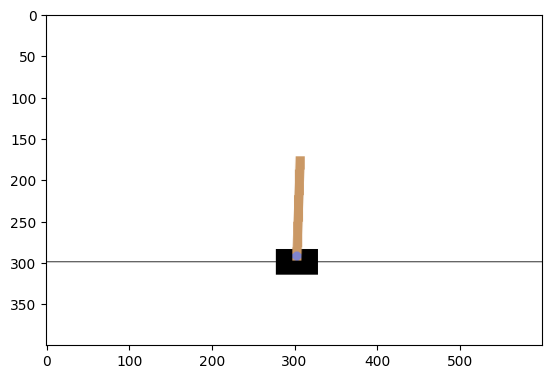

In [2]:
env = gym.make('CartPole-v0')
seed_everything(env)

env.reset()
plt.imshow(env.render(mode='rgb_array'))

In [3]:
state_dims = env.observation_space.shape[0]
num_actions = env.action_space.n 

print(f'CartPole env : State dimensions : {state_dims}, Number of actions : {num_actions}')


CartPole env : State dimensions : 4, Number of actions : 2


In [4]:
env = PreprocessEnv(env)
state = env.reset()
action = torch.tensor(0)
next_state, reward, done, _ = env.step(action)

In [5]:
# Create Q-network

q_network = nn.Sequential(
    nn.Linear(state_dims, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, num_actions)
)



In [6]:
# Create target network

target_q_network = copy.deepcopy(q_network).eval()

In [7]:
# Create the exploratory policy : b(s)

def policy(state, epsilon=0.):
    if torch.rand(1) < epsilon:
        return torch.randint(num_actions, (1, 1))
    else:
        av = q_network(state).detach()
        return torch.argmax(av, dim=-1, keepdim=True)
    

In [ ]:
# Craete the Experience Replay Buffer

class RelayMemory:

    def __init__(self, capacity=1e6):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    # Insert [s, a, r, s']
    def insert(self, transition):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = transition
        self.position = (self.position + 1) % int(self.capacity)
        
    # Sample [[s, a, r, s'], [s, a, r, s']]
    def sample(self, batch_size):
        assert self.can_sample(batch_size)

        batch = random.sample(self.memory, batch_size)

        # [[s,a,r,s'], [s,a,r,s'],[s,a,r,s']] -> [[s,s,s],[a,a,a],[r,r,r],[s',s',s']]
        batch = zip(*batch)
        return [torch.cat(items) for items in batch] # N x D


    # can_sample -> True/False
    def can_sample(self, batch_size):
        return len(self.memory) >= batch_size * 10

    # __len__
    def __len__(self):
        return len(self.memory)

In [17]:
# Implement the algorithm

def deep_q_learning(q_network, policy, episodes, alpha=1e-4, batch_size=32, gamma=0.99, epsilon=0.2):
    optim = AdamW(q_network.parameters(), lr=alpha)
    memory = RelayMemory()
    stats = {'MSE Loss' : [], 'Returns' : []}

    for episode in tqdm(range(1, 1 + episodes)):
        state = env.reset()
        done = False
        ep_return = 0

        while not done:
            action = policy(state, epsilon)
            next_state, reward, done, _ = env.step(action)

            memory.insert([state, action, reward, done, next_state])

            if memory.can_sample(batch_size):
                state_b, action_b, reward_b, done_b, next_state_b = memory.sample(batch_size)
                qsa_b = q_network(state_b).gather(1, action_b)

                next_qsa_b = target_q_network(next_state_b)
                next_qsa_b = torch.max(next_qsa_b, dim=-1, keepdim=True)[0]

                target_b = reward_b + ~done_b * gamma * next_qsa_b
                loss = F.mse_loss(qsa_b, target_b)

                q_network.zero_grad()
                loss.backward()
                optim.step()

                stats['MSE Loss'].append(loss.item())

            state = next_state
            ep_return += reward.item()
    
        stats['Returns'].append(ep_return)

        if episode % 10 == 0:
            target_q_network.load_state_dict(q_network.state_dict())

    return stats
    

In [21]:
q_network = nn.Sequential(
    nn.Linear(state_dims, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, num_actions)
)

target_q_network = copy.deepcopy(q_network).eval()

stats = deep_q_learning(q_network, policy, 500)

100%|██████████| 500/500 [00:49<00:00, 10.16it/s]


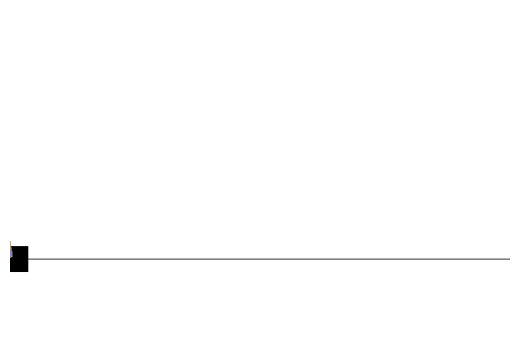

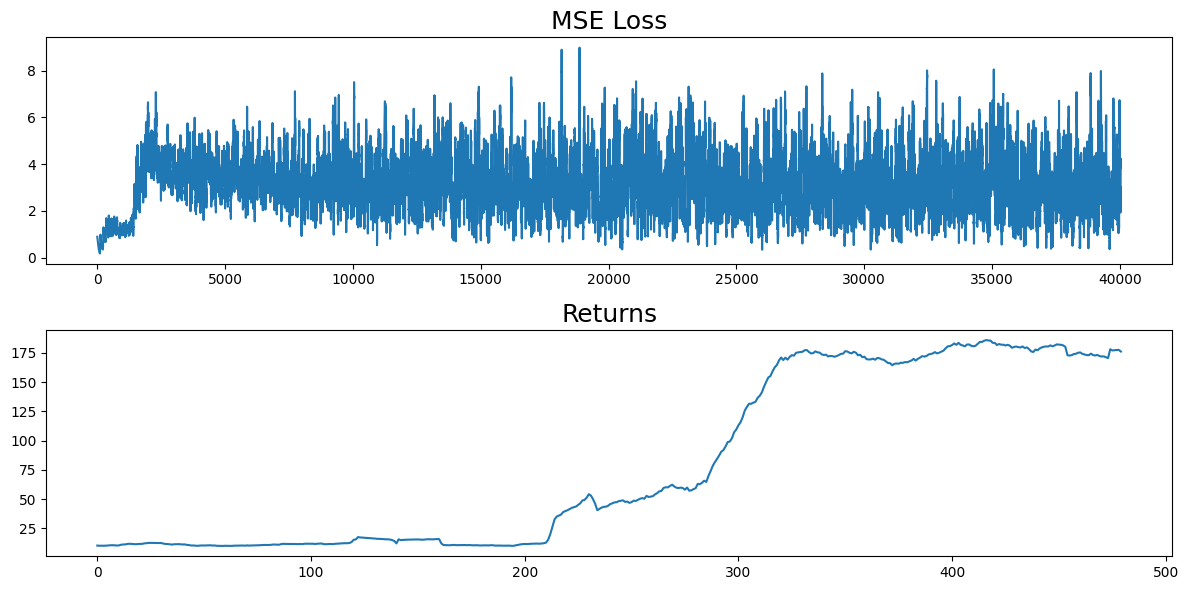

In [22]:
plot_stats(stats)

In [23]:
test_agent(env, policy, episodes=2)

In [24]:
env.close()